<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transfer learning with tensorflow part 3: scaling up (food vision mini)

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).
Our baseline to beat is 50.76% accuracy across 101 classes.

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-10-14 20:44:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-10-14 20:44:39 (91.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys, unzip_data

## 101 food classes: working with less data

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-10-14 20:44:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 172.217.194.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  23.0MB/s    in 69s     

2025-10-14 20:45:49 (22.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 

In [9]:
# setup data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* create a ModelChecpoint callback
* create a data augmentation layer to build data augmentation right in the model
* build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* compile our model
* feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data to save epoch time)

In [10]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [11]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name = "data_augmentation")

In [12]:
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weigts which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
# Get the summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.1562 - loss: 3.9722 - val_accuracy: 0.4632 - val_loss: 2.4902
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 157ms/step - accuracy: 0.4671 - loss: 2.3335 - val_accuracy: 0.5180 - val_loss: 2.0342
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.5456 - loss: 1.9089 - val_accuracy: 0.5373 - val_loss: 1.8506
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.5862 - loss: 1.6827 - val_accuracy: 0.5479 - val_loss: 1.7915
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.6192 - loss: 1.5353 - val_accuracy: 0.5665 - val_loss: 1.7039


In [15]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5676 - loss: 1.6697


[1.5884554386138916, 0.5838811993598938]

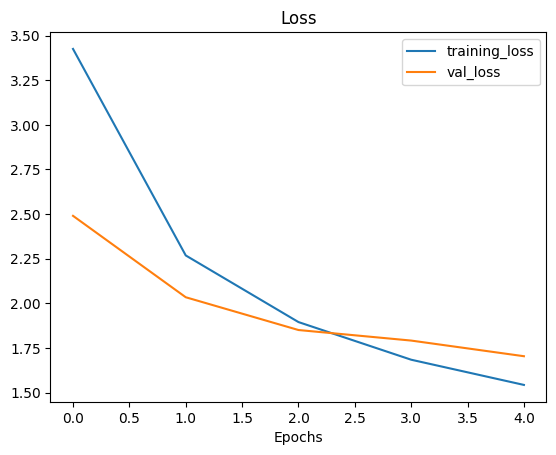

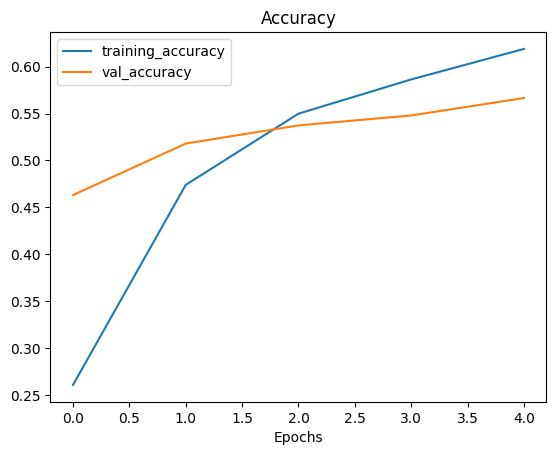

In [16]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning_rate reduced by 10x
              metrics=["accuracy"])

In [19]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.6363 - loss: 1.5009 - val_accuracy: 0.5651 - val_loss: 1.6846
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accuracy: 0.6782 - loss: 1.3058 - val_accuracy: 0.5691 - val_loss: 1.6616
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.6935 - loss: 1.2391 - val_accuracy: 0.5773 - val_loss: 1.6265
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.7116 - loss: 1.1695 - val_accuracy: 0.5890 - val_loss: 1.5770
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 153ms/step - accuracy: 0.7380 - loss: 1.1164 - val_accuracy: 0.5858 - val_loss: 1.5786
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.7393 - loss: 1.0559 - val_accuracy: 0.5866 - val_loss: 1.5757


In [22]:
# Evaluate the whole test_data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5972 - loss: 1.5072


[1.4136508703231812, 0.6170297265052795]

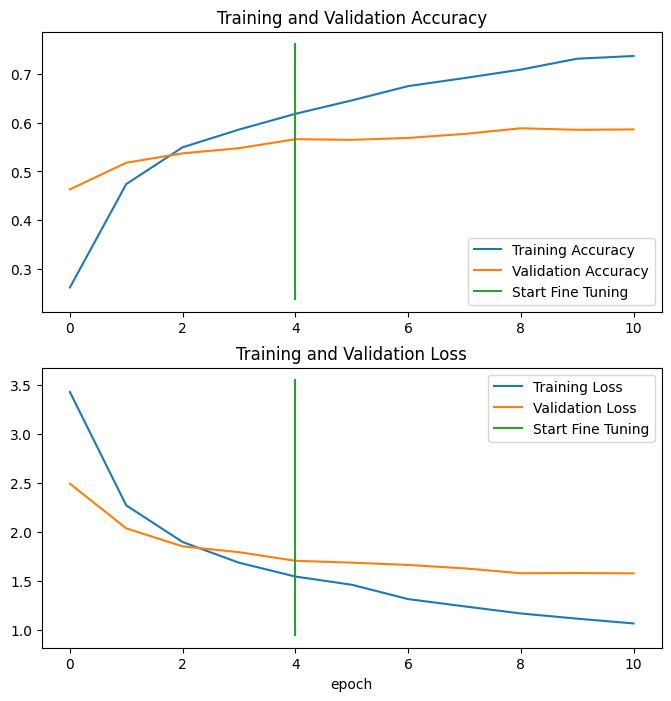

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent_fine_tune,
                  initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [24]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [25]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [26]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - accuracy: 0.5972 - loss: 1.5072


[1.4136508703231812, 0.6170297265052795]

In [27]:
# The results from ourloaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4136508703231812, 0.6170297265052795]

## Evaluating the performance of the big dog model across all different classes
Let'smake some predictions, visualize them and then later find out which predictions were the "most" wrong

In [28]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_classes_10_percent_saved_big_dog_model.zip

--2025-10-14 20:58:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_classes_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 172.253.118.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-10-14 20:58:13 ERROR 403: Forbidden.

